In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_boundaries(freqval, lower_bpm, higher_bpm):
    lower_limit = float(lower_bpm)/60 
    upper_limit = float(higher_bpm)/60
    start = -1
    for i in xrange(len(freqval)):
        if freqval[i] >= lower_limit:
            start = i
            break
    end = -1
    for i in xrange(len(freqval)):
        if freqval[i] >= upper_limit:
            end = i
            break

    if start == -1 or end == -1:
        return None # insufficient freq values
    return start, end

def find_peak_within_range(fftval, start, end):
    peak = 0.0
    peak_freq = -1
    for i in xrange(start, end):
        if fftval[i-1]<fftval[i]>fftval[i+1] and fftval[i] > peak:
            peak = fftval[i]
            peak_freq = i
    return peak_freq


def cal_heart_rate(fftval, freqval):
    start, end = filter_boundaries(freqval, 50.0, 220.0)
    peak_freq = find_peak_within_range(fftval, start, end)
    return freqval[peak_freq]

def cal_resp_rate(fftval, freqval):
    start, end = filter_boundaries(freqval, 8, 22)
    peak_freq = find_peak_within_range(fftval, start, end)
    return freqval[peak_freq]


def findMaxMins(arr):
    maximas = list()
    minimas = list()
    for i in xrange(1, len(arr)-1):
        if arr[i-1]<arr[i]>arr[i+1]:
            maximas.append(i)
        if arr[i-1]>arr[i]<arr[i+1]:
            minimas.append(i)
    return maximas, minimas

data = np.genfromtxt("/Users/bhushan/Desktop/AWS_IR/running_jithu_1.csv",delimiter=",", skip_header=1, dtype=float)
data_mod = np.empty((data.shape[0], 2))
data_mod[:,:] = data[:,0:2]

# Interpolation
x_new = np.arange(data[0,0], data[-1,0], 20.0)
y_new = np.interp(x_new, data[:,0], data[:,1])
########### Heart rate and respiration rate calculation ##########
signal = y_new
sample_freq = 50
timestep = 1.0/sample_freq
# Number of windows
num_splits = 5
HEART_RATE = 0.0
RESP_RATE = 0.0

final_heart_rate_array = []
final_resp_rate_array = []
for subarr in np.array_split(signal, num_splits):
    avg = np.mean(subarr)
    subarr = subarr-avg
    fourier = np.fft.fft(subarr)
    abs_val = abs(fourier)**2
    freq = np.fft.fftfreq(subarr.size, d=timestep)
     
    heart_rate_freq = cal_heart_rate(abs_val, freq)
    filtered_signal = butter_bandpass_filter(subarr, heart_rate_freq-0.25, heart_rate_freq+0.25, sample_freq)
    maxs, mins = findMaxMins(filtered_signal[1000:])
    heartrate_arr = [(60*50/float(maxs[i]-maxs[i-1])) for i in range(1, len(maxs))]
    final_heart_rate_array.extend(heartrate_arr)
    HEART_RATE += np.mean(heartrate_arr)/num_splits

    resp_rate_freq = cal_resp_rate(abs_val, freq)
    filtered_signal = butter_bandpass_filter(subarr, 0.1, 0.4, sample_freq, order = 4)
    maxs, mins = findMaxMins(filtered_signal[1000:])
    resprate_arr = [(60*50/float(maxs[i]-maxs[i-1])) for i in range(1, len(maxs))]
    final_resp_rate_array.extend(resprate_arr)
    resprate_arr = filter(lambda x: 6<x<24,  resprate_arr)
    RESP_RATE += np.mean(resprate_arr)/num_splits

print "Final Heart Rate:- ", np.mean(final_heart_rate_array)
print "Final Respiration Rate:- ", np.mean(final_resp_rate_array)

Final Heart Rate:-  163.852710851
Final Respiration Rate:-  21.3213063506


SpO2 values:- 
[99.949510685340073, 80.349167904894728, 93.988231148002143, 86.756954790111365, 89.407786302719785, 94.342390614558028, 85.15187814119912, 94.740647428781969, 93.882753366607162, 91.604644403253587, 98.645191179650382, 96.248624097812126, 82.279117828112135, 84.18299109752293, 81.665442938502338, 92.857662606900732, 82.518032970892293, 82.3584523124904, 96.888048449665789, 85.831207761950793, 80.93180990279096, 87.735191680087055, 87.883767988066097, 83.494606922917654, 80.261189594227744, 88.459065357141313, 87.825243945357954, 80.481348143069141, 89.960049240585022, 99.931275844450212, 98.591548359988835, 85.820844597243479, 91.120341059030068, 87.042156214699247, 87.987958654122508, 87.756499435591124, 84.140384900935516, 92.698133156195681, 93.745532421319467, 93.642227880990646, 87.669239701212589, 96.377063095400217, 91.842136872862369, 92.110476032801472, 95.756856879888247, 90.00407742033795, 85.910926064806091, 89.200902679277633, 92.031369923434596, 96.0334492

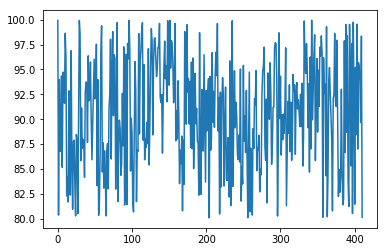

In [45]:
######## SPO2 Calculation ########
IR = data[:, 1]
RED = data[:, 2]

IR = np.interp(x_new, X, IR)
RED = np.interp(x_new, X, RED)

# Filtering IR and RED signal to remove Noise
IR = butter_lowpass_filter(IR, 2, sample_freq, 6)[100:]
RED = butter_lowpass_filter(RED, 2, sample_freq, 6)[100:]
# Finding minimas and maximas
xvals = [_ for _ in xrange(len(IR))]
red_maxs, red_mins = findMaxMins(RED)
ir_maxs, ir_mins = findMaxMins(IR)
# Calculating interpolation for minimas in RED signal
red_yvals = [RED[i] for i in red_mins]
red_yinterp = np.interp(xvals, red_mins, red_yvals)
# Calculating interpolation for minimas in IR signal
ir_yvals = [IR[i] for i in ir_mins]
ir_yinterp = np.interp(xvals, ir_mins, ir_yvals)

# Calculating AC and DC component in IR and RED signal
AC_IR = [(IR[i] - ir_yinterp[i]) for i in ir_maxs]
DC_IR = [ir_yinterp[i] for i in ir_maxs]
AC_RED = [(RED[i] - red_yinterp[i]) for i in ir_maxs]
DC_RED = [red_yinterp[i] for i in ir_maxs]

# Calculating SpO2
spo2ans = []    
for i in range(len(AC_RED)):
    rat = (AC_RED[i]*DC_IR[i])/(AC_IR[i]*DC_RED[i])
    spo2_itr = -45.060* rat * rat + 30.354 * rat + 94.845
    if spo2_itr > 80.0 and spo2_itr<100.0:
        spo2ans.append(spo2_itr)
print "SpO2 values:- "
print spo2ans
print "Final SpO2:- ", np.mean(spo2ans)

plt.plot(spo2ans)
plt.show()

